# INF8225 Project - Fine Tuned CNNs for image classification on CIFAR-10 and CIFAR-100 datasets

We are going to analyze and compare the performances of the 4 following CNNs :
- ResNet50-v2
- DenseNet-121



# Imports and data initialization

In [2]:
from matplotlib import pyplot

from keras.datasets import cifar10, cifar100
from keras.utils import to_categorical, np_utils
from keras import layers
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout, MaxPool2D
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import torch.nn as nn

from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_epochs = 5
batch_size = 40
learning_rate = 0.001

cuda


## CIFAR-10

170498071/170498071 [==============================] - 13s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


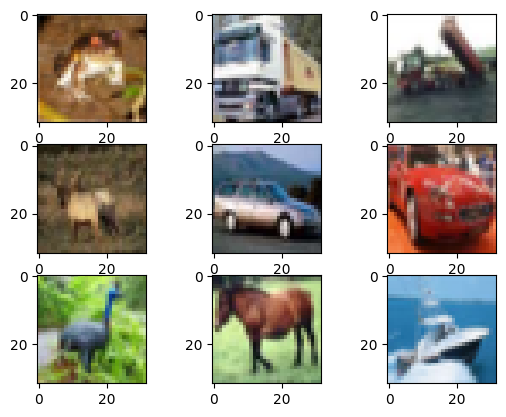

In [4]:
# load cifar10 dataset

(trainX_cifar10, trainY_cifar10), (testX_cifar10, testY_cifar10) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX_cifar10.shape, trainY_cifar10.shape))
print('Test: X=%s, y=%s' % (testX_cifar10.shape, testY_cifar10.shape))
# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # plot raw pixel data
 pyplot.imshow(trainX_cifar10[i])
# show the figure
pyplot.show()

## CIFAR-100

169001437/169001437 [==============================] - 13s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


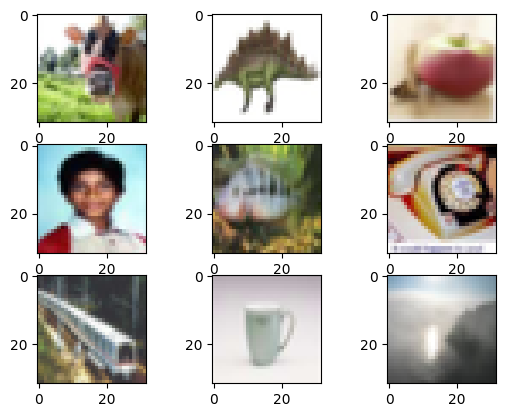

In [5]:
# load dataset

(trainX_cifar100, trainY_cifar100), (testX_cifar100, testY_cifar100) = cifar100.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX_cifar100.shape, trainY_cifar100.shape))
print('Test: X=%s, y=%s' % (testX_cifar100.shape, testY_cifar100.shape))
# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # plot raw pixel data
 pyplot.imshow(trainX_cifar100[i])
# show the figure
pyplot.show()

## Preprocessing

In [6]:
# one hot encode target values

trainY_cifar10 = to_categorical(trainY_cifar10)
testY_cifar10 = to_categorical(testY_cifar10)

In [7]:
# one hot encode target values
trainY_cifar100 = to_categorical(trainY_cifar100)
testY_cifar100 = to_categorical(testY_cifar100)

## Data augmentation

In [8]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255) # We simply normalize the pixels values

In [9]:
# CIFAR-10 Train and validation set 
train_datagen.fit(trainX_cifar10)
train_generator_cifar10 = train_datagen.flow(trainX_cifar10, trainY_cifar10, batch_size=32)

validation_generator_cifar10 = test_datagen.flow(testX_cifar10, testY_cifar10, batch_size=32)

In [10]:
# CIFAR-100 Train and validation set
train_datagen.fit(trainX_cifar100)
train_generator_cifar100 = train_datagen.flow(trainX_cifar100, trainY_cifar100, batch_size=32)

validation_generator_cifar100 = test_datagen.flow(testX_cifar100, testY_cifar100, batch_size=32)

In [11]:
# Normalize test dataset pixels
test_generator_cifar10 = test_datagen.flow(testX_cifar10, testY_cifar10, batch_size=32)
test_generator_cifar100 = test_datagen.flow(testX_cifar100, testY_cifar100, batch_size=32)

## Setting Hyperparameters

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
filepath = "setting_" + "model2" + ".hdf5"
logfilepath = "setting_"+"model2" + ".csv"
reduce_lr_rate=0.5
logCallback = CSVLogger(logfilepath, separator=',', append=False)
earlyStopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, verbose=1, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_weights_only=True, verbose=1,
                             save_best_only=True, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=reduce_lr_rate, patience=1,
                              cooldown=0, min_lr=0.00001, verbose=1)

callbacks_list = [logCallback, earlyStopping, reduce_lr, checkpoint]

# Model architectures

## Hyper-parameters

In [13]:
NB_EPOCHS = 50
nb_train_samples = trainX_cifar100.shape[0]
nb_validation_samples = testX_cifar100.shape[0]

## 2. ResNet50-v2 
The ResNet50V2 architecture is a variant of the original ResNet architecture, which introduces a residual block that includes a shortcut connection to bypass the convolutional layers. This helps to mitigate the vanishing gradient problem and allows the network to learn deeper representations. The ResNet50V2 architecture includes multiple residual blocks, where each block consists of several convolutional layers with batch normalization and a ReLU activation function, followed by a shortcut connection and another batch normalization and ReLU activation. The architecture also includes pooling layers and a fully connected layer for classification.

The code defines a Keras model based on the ResNet50V2 architecture, which can be used for image classification with the specified number of output classes.





In [14]:
def resnet50_v2(num_classes):
    return tf.keras.applications.ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='max',
        classes=num_classes,
        classifier_activation='softmax'
    )

resnet50v2_10 = resnet50_v2(10)  # CIFAR-10
resnet50v2_100 = resnet50_v2(100)  # CIFAR-100

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))

def build_custom_resnet50v2(base_model, nb_classes):
    last = base_model.get_layer('conv5_block3_out').output

    # Add classification layers on top of it
    x = GlobalAveragePooling2D()(last)
    if nb_classes == 100:
        x = Dense(2048, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(2048, activation='relu')(x)
    else:
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)

    pred = Dense(nb_classes, activation='softmax')(x)

    model = Model(base_model.input, pred)

    # set the base model's layers to non-trainable
    # uncomment next two lines if you don't want to
    # train the base model
    # for layer in base_model.layers:
    #     layer.trainable = False

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(loss='categorical_crossentropy',
                optimizer=SGD(learning_rate=1e-3, momentum=0.9),
                metrics=['accuracy'])
  
    return model

94668760/94668760 [==============================] - 5s 0us/step


### Cifar 10

In [15]:
resnet50v2_10 = build_custom_resnet50v2(resnet50v2_10,10)
print(resnet50v2_10.summary())

resnet50v2_10_hist = resnet50v2_10.fit(
    train_generator_cifar10, 
    steps_per_epoch=nb_train_samples//NB_EPOCHS,
    validation_data=validation_generator_cifar10,
    epochs=50, batch_size=256,
    verbose=1, shuffle=True,
    callbacks=callbacks_list
    )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
import pickle
# Save the history of the trained model to a file
with open('resnet50v2_10_hist_history.pickle', 'wb') as file:
    pickle.dump(resnet50v2_10_hist.history, file)

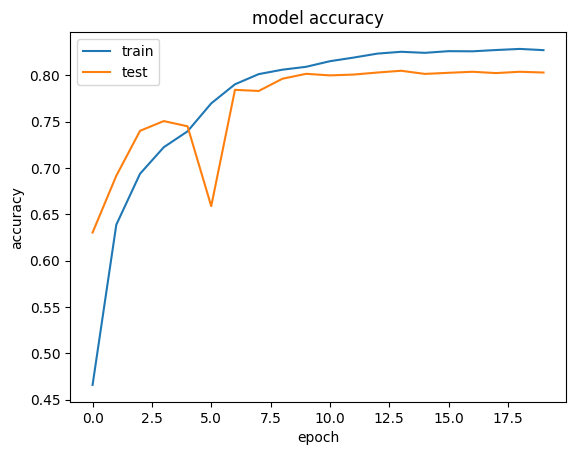

In [17]:
plt.plot(resnet50v2_10_hist.history['accuracy'])
plt.plot(resnet50v2_10_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

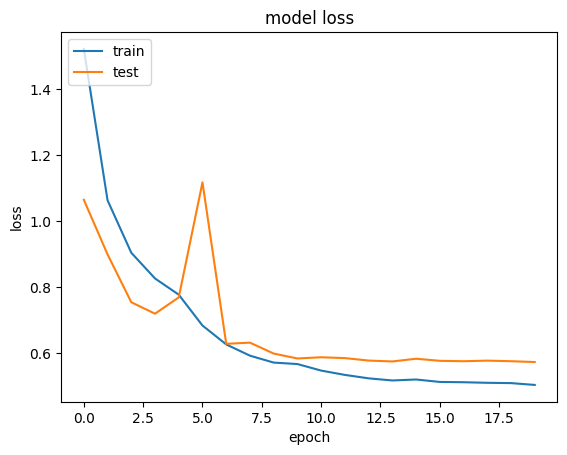

In [18]:
plt.plot(resnet50v2_10_hist.history['loss'])
plt.plot(resnet50v2_10_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## CIFAR-100 for ResidualNet50-V2

In [19]:
resnet50v2_100 = build_custom_resnet50v2(resnet50v2_100,100)
resnet50v2_100.summary()

resnet50v2_100_hist = resnet50v2_100.fit(
    train_generator_cifar100, 
    steps_per_epoch=nb_train_samples//NB_EPOCHS,
    validation_data=validation_generator_cifar100,
    batch_size=256,
    verbose=1, shuffle=True,
    callbacks=callbacks_list,
    epochs=50
    )

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [20]:
import pickle

with open('resnet50v2_100_hist_history.pickle', 'wb') as file:
    pickle.dump(resnet50v2_100_hist.history, file)

## Plot of CIFAR-100 for ResidualNet50-V2

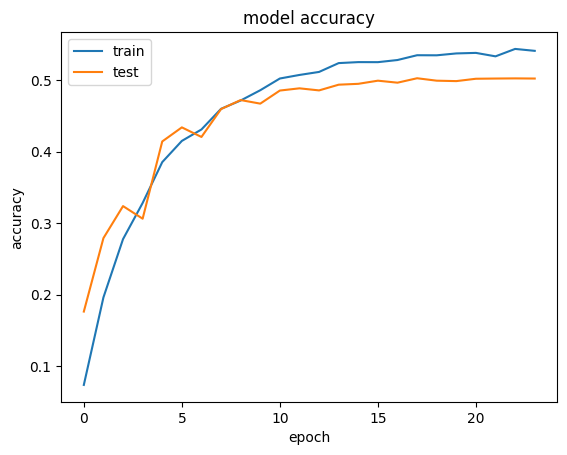

In [21]:
plt.plot(resnet50v2_100_hist.history['accuracy'])
plt.plot(resnet50v2_100_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

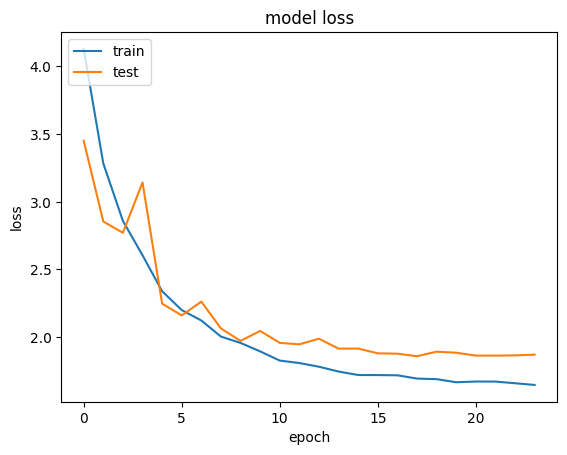

In [22]:
plt.plot(resnet50v2_100_hist.history['loss'])
plt.plot(resnet50v2_100_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 4. DenseNet-121

The DenseNet121 architecture is a convolutional neural network that uses densely connected layers, where each layer receives input from all preceding layers, allowing the network to learn more complex and diverse features. The architecture includes multiple dense blocks, where each block consists of several convolutional layers with batch normalization and a ReLU activation function, followed by a transition layer that performs spatial compression through pooling.
This below code defines a Keras model based on the DenseNet121 architecture, which can be used for image classification with the specified number of output classes.

In [23]:
def densenet121(nb_classes):
  return tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='max',
    classes=nb_classes,
    classifier_activation='softmax'
  )

In [24]:
densenet121_10 = densenet121(10)  # CIFAR-10
densenet121_100 = densenet121(100)  # CIFAR-100

29084464/29084464 [==============================] - 2s 0us/step


In [25]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD

# Define the base model
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(32,32,3))

def build_custom_densenet121(base_model, nb_classes):
    # Set the layers of the base model to non-trainable
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add classification layers on top of it
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    pred = Dense(nb_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=pred)

    # Compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(loss='categorical_crossentropy',
                  optimizer=SGD(learning_rate=1e-3, momentum=0.9),
                  metrics=['accuracy'])
    
    return model


### CIFAR 10

In [26]:
densenet121_10 = build_custom_densenet121(base_model, 10)

# Print the model summary
densenet121_10.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_6[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d_4[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']       

In [27]:
densenet121_10_hist = densenet121_10.fit(
    train_generator_cifar10, 
    steps_per_epoch=nb_train_samples//NB_EPOCHS,
    validation_data=validation_generator_cifar10,
    epochs = 50, batch_size=256,
    verbose=1, shuffle=True,
    callbacks=callbacks_list
    )

Epoch 1/50
1000/1000 [==============================] - ETA: 0s - loss: 1.7233 - accuracy: 0.3970
Epoch 1: val_accuracy did not improve from 0.80500
1000/1000 [==============================] - 46s 38ms/step - loss: 1.7233 - accuracy: 0.3970 - val_loss: 1.3228 - val_accuracy: 0.5466 - lr: 0.0010
Epoch 2/50
1000/1000 [==============================] - ETA: 0s - loss: 1.4458 - accuracy: 0.4873
Epoch 2: val_accuracy did not improve from 0.80500
1000/1000 [==============================] - 35s 35ms/step - loss: 1.4458 - accuracy: 0.4873 - val_loss: 1.2378 - val_accuracy: 0.5723 - lr: 0.0010
Epoch 3/50
 999/1000 [============================>.] - ETA: 0s - loss: 1.3665 - accuracy: 0.5158
Epoch 3: val_accuracy did not improve from 0.80500
1000/1000 [==============================] - 35s 35ms/step - loss: 1.3666 - accuracy: 0.5157 - val_loss: 1.2018 - val_accuracy: 0.5826 - lr: 0.0010
Epoch 4/50
1000/1000 [==============================] - ETA: 0s - loss: 1.3333 - accuracy: 0.5304
Epoch 4: va

In [28]:
import pickle

with open('densenet121_10_hist.pickle', 'wb') as file:
    pickle.dump(densenet121_10_hist.history, file)

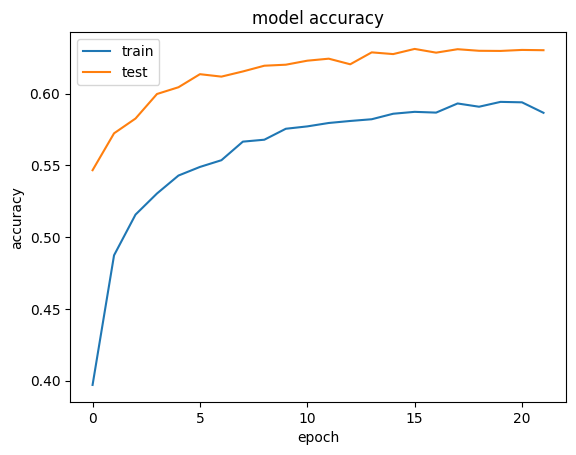

In [29]:
plt.plot(densenet121_10_hist.history['accuracy'])
plt.plot(densenet121_10_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

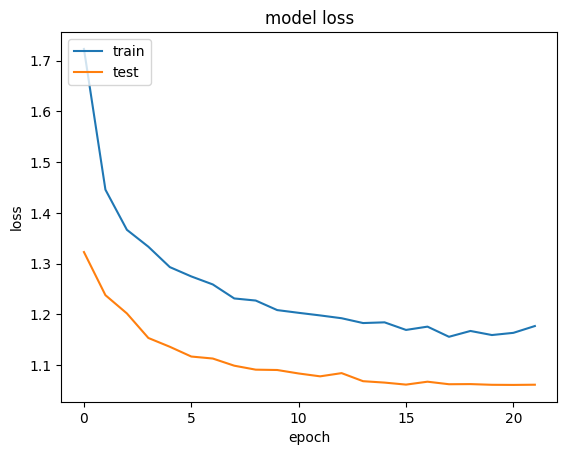

In [30]:
plt.plot(densenet121_10_hist.history['loss'])
plt.plot(densenet121_10_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##CIFAR-100 Dataset

In [31]:
densenet121_100 = build_custom_densenet121(base_model,100)

# Print the model summary
densenet121_100.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_6[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d_4[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']       

In [32]:
densenet121_100_hist = densenet121_100.fit(
    train_generator_cifar100, 
    steps_per_epoch=nb_train_samples//NB_EPOCHS,
    validation_data=validation_generator_cifar100,
    epochs = 50, batch_size=256,
    verbose=1, shuffle=True,
    callbacks=callbacks_list
    )

Epoch 1/50
 999/1000 [============================>.] - ETA: 0s - loss: 4.3277 - accuracy: 0.0672
Epoch 1: val_accuracy did not improve from 0.80500
1000/1000 [==============================] - 47s 39ms/step - loss: 4.3272 - accuracy: 0.0673 - val_loss: 3.6838 - val_accuracy: 0.1738 - lr: 0.0010
Epoch 2/50
1000/1000 [==============================] - ETA: 0s - loss: 3.7429 - accuracy: 0.1414
Epoch 2: val_accuracy did not improve from 0.80500
1000/1000 [==============================] - 37s 37ms/step - loss: 3.7429 - accuracy: 0.1414 - val_loss: 3.2346 - val_accuracy: 0.2385 - lr: 0.0010
Epoch 3/50
1000/1000 [==============================] - ETA: 0s - loss: 3.4781 - accuracy: 0.1835
Epoch 3: val_accuracy did not improve from 0.80500
1000/1000 [==============================] - 37s 37ms/step - loss: 3.4781 - accuracy: 0.1835 - val_loss: 3.0565 - val_accuracy: 0.2724 - lr: 0.0010
Epoch 4/50
 999/1000 [============================>.] - ETA: 0s - loss: 3.3128 - accuracy: 0.2099
Epoch 4: va

In [33]:
import pickle

with open('densenet121_100_hist.pickle', 'wb') as file:
    pickle.dump(densenet121_100_hist.history, file)

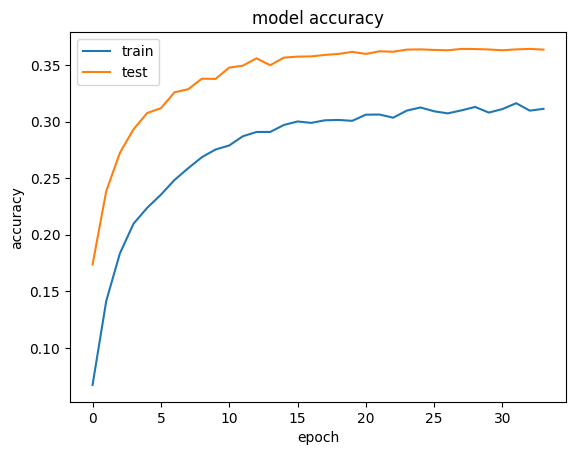

In [34]:
plt.plot(densenet121_100_hist.history['accuracy'])
plt.plot(densenet121_100_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

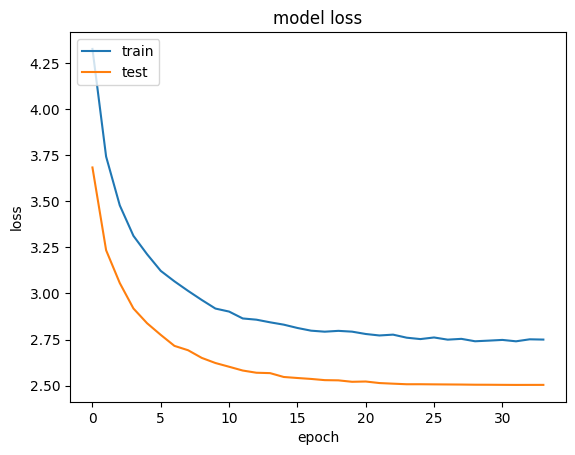

In [35]:
plt.plot(densenet121_100_hist.history['loss'])
plt.plot(densenet121_100_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()